In [2]:
import tensorflow as tf
import numpy as np
import sklearn as sk
from sklearn.datasets import make_classification
import scikitplot as skplt
import pandas as pd
import copy
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import load_model

In [3]:
#############################
# PART I: Preparing Dataset.#
# @Elvis                    #
#############################
# The following code assumes that: 
# 1: .CSV files contains all hand gestures.
# 2: frame column exits. (This will be handled here).
# 3: 20 landmarks for each side of hand. (40 in total).

import os
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

# Macros
LANDMARKS_NUM            = 80
LANDMARS_OFFSET          = 4
INDEX_FRAME              = 1
INDEX_CAMERA_FACING_SIDE = 2
INDEX_SOURCE             = 0
DATASET_PATH             = 'dataset/subsystem_2/Dataset_subsystem_2.csv'
# Pre processing params
shuffle    = True         # Shuffle data before using.
dropout    = False        # Dropout regularization.
gradcheck  = False        # Gradient checking. 
moredata   = False        # Extend dataset adding modifications of data.
test_size  = 0.10         # Train, dev, test percentage. 

# Conditions
conds = ["open_palm", "open_dorsal", "fist_palm", "fist_dorsal", "three_fingers_palm", "three_fingers_dorsal"]

# Loading final dataset!TODO: Add script to check if correct imported.
dbase = pd.read_csv(DATASET_PATH, sep=",")

#To put the number of the class in the ID column
for i in range(len(dbase)):
    string = dbase.iloc[i]["camera_facing_side"] + '_' + dbase.iloc[i]["gesture"]
    dbase.at[i,"ID"] = conds.index(string)
    
#to select relevant data for classification

Yfeatures = dbase.columns[0]
Xfeatures = dbase.columns[4:]
print(f'Shape imported data: {dbase.shape}')




Shape imported data: (62219, 84)


In [4]:
Xfeatures

Index(['palm_root_x', 'palm_root_y', 'palm_thumb_1_x', 'palm_thumb_1_y',
       'palm_thumb_2_x', 'palm_thumb_2_y', 'palm_thumb_3_x', 'palm_thumb_3_y',
       'palm_index_1_x', 'palm_index_1_y', 'palm_index_2_x', 'palm_index_2_y',
       'palm_index_3_x', 'palm_index_3_y', 'palm_index_4_x', 'palm_index_4_y',
       'palm_middle_1_x', 'palm_middle_1_y', 'palm_middle_2_x',
       'palm_middle_2_y', 'palm_middle_3_x', 'palm_middle_3_y',
       'palm_middle_4_x', 'palm_middle_4_y', 'palm_ring_1_x', 'palm_ring_1_y',
       'palm_ring_2_x', 'palm_ring_2_y', 'palm_ring_3_x', 'palm_ring_3_y',
       'palm_ring_4_x', 'palm_ring_4_y', 'palm_pinky_1_x', 'palm_pinky_1_y',
       'palm_pinky_2_x', 'palm_pinky_2_y', 'palm_pinky_3_x', 'palm_pinky_3_y',
       'palm_pinky_4_x', 'palm_pinky_4_y', 'dorsal_root_x', 'dorsal_root_y',
       'dorsal_thumb_1_x', 'dorsal_thumb_1_y', 'dorsal_thumb_2_x',
       'dorsal_thumb_2_y', 'dorsal_thumb_3_x', 'dorsal_thumb_3_y',
       'dorsal_index_1_x', 'dorsal_index_

In [5]:
# Separting data and labels
X = dbase[Xfeatures].to_numpy(dtype=np.float32)
Y = dbase[Yfeatures].to_numpy(dtype=np.float32)

# Display random hand gestures.
#!TODO: finish this.

# One hot encoding using Sklearn
onehot_encoder = sk.preprocessing.OneHotEncoder(dtype=np.float32)
onehot_encoder.fit(Y.reshape((-1,1))) # Encoding is [open, first, three_fingers, dorsal, palm]

Y_encoded = onehot_encoder.transform(Y.reshape((-1,1))).toarray()
# onehot_encoded.shape
# Use the line below to invert element of index'IDX'.
#inverted = label_encoder.inverse_transform([np.argmax(onehot_encoded[IDX, :])])

# Split data into train and test sets. Shuffe data if param enabled.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = test_size, shuffle=shuffle)
# print(f'\nShape of training set\t: {X_train.shape}\nShape of test set\t: {X_test.shape}')

In [6]:
Y_train

array([2., 0., 1., ..., 2., 1., 5.], dtype=float32)

In [7]:
Y_train_encoded = onehot_encoder.transform(Y_train.reshape((-1,1))).toarray()
Y_test_encoded = onehot_encoder.transform(Y_test.reshape((-1,1))).toarray()


In [8]:
# this snippet will dissapear at some point in the future
# it exists because I found two bugs in KerasClassifier while writing
# this notebook. 
# Issues are raised in the tensorflow repo and this should be fixed soon(TM)

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier 

class KerasClassifier_Patched(KerasClassifier):
    # bugfix: classifier doesn't declare that it is a classifier
    # in the Scikit learn API
    _estimator_type = "classifier"
    
    # bugfix: the current wrapper does not work with HotOne encoded
    # labels
    # this is only a fix in the specific case of this notebook,
    # not a general one
    def score(self, x, y, **kwargs):
        _, accuracy = self.model.evaluate(x,y, verbose=0, **kwargs)
        return accuracy

In [9]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

def setupModel(): #very similar to the one from Lab 2
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape=(80)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(6))
    model.add(tf.keras.layers.Softmax())
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4),
                 loss=tf.keras.losses.CategoricalCrossentropy(),
                 metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return model

final_model = KerasClassifier_Patched(build_fn=setupModel,
                               epochs=3,
                               batch_size=50,
                               verbose=1)

In [10]:
#Model training
final_model.fit(X_train,Y_train_encoded)

Train on 55997 samples
Epoch 1/3
55997/55997 [==============================] - 2s 31us/sample - loss: 3.2910 - categorical_accuracy: 0.9676
Epoch 2/3
55997/55997 [==============================] - 1s 27us/sample - loss: 0.0210 - categorical_accuracy: 0.9989
Epoch 3/3
55997/55997 [==============================] - 1s 26us/sample - loss: 0.0095 - categorical_accuracy: 0.9996


In [11]:
#testing model accuracy
test_accuracy = final_model.score(X_test, Y_test_encoded)
test_accuracy

0.9998393

In [12]:
Y_test

array([4., 1., 3., ..., 0., 2., 3.], dtype=float32)

6222/6222 [==============================] - 0s 20us/sample


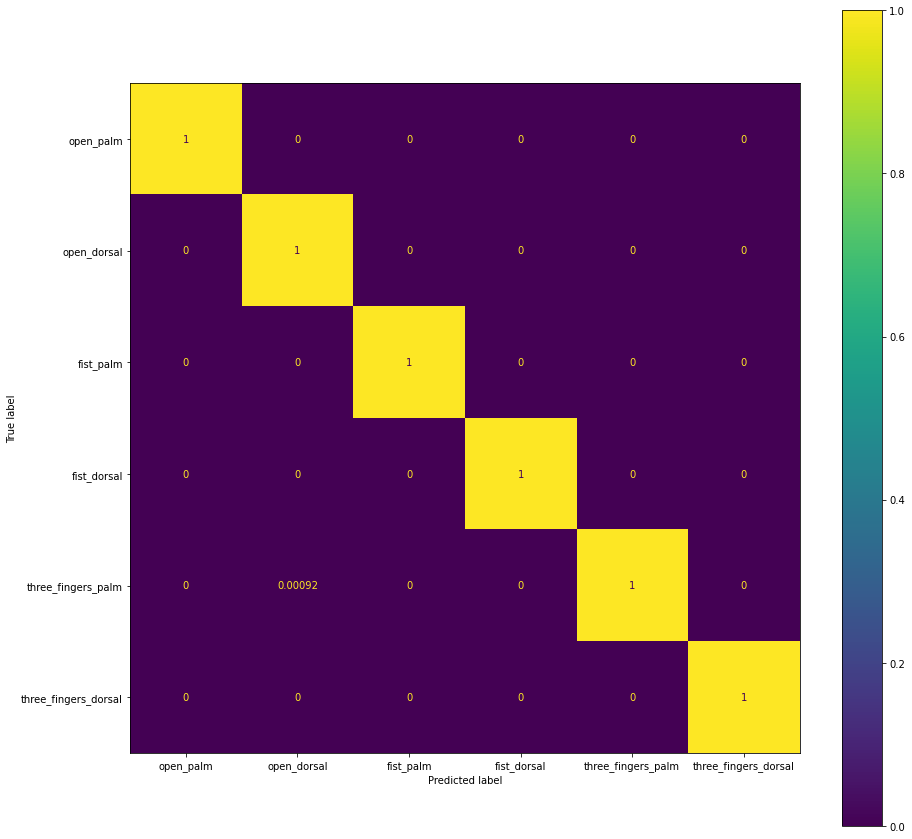

In [13]:
#confusion matrix
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15,15]
sk.metrics.plot_confusion_matrix(final_model,X_test,Y_test,normalize="pred",display_labels=conds)

In [26]:
# reminder: conds = ["open_palm", "open_dorsal", "fist_palm", "fist_dorsal", "three_fingers_palm", "three_fingers_dorsal"]
X_test
final_model.predict(X_test)

6222/6222 [==============================] - 0s 21us/sample


array([4, 1, 3, ..., 0, 2, 3])

In [ ]:
from sklearn.model_selection import cross_val_score

folds = 3 # number of chunks to split the dataset into
scores = cross_val_score(final_model, X, Y_encoded, cv=folds)
print(f"Accuracy: {scores.mean():.2f} Standard Deviation: {scores.std():0.4f}")

In [ ]:
scores

In [33]:
# Saving the model
final_model_json = final_model.model.to_json()
with open("final_model.json", "w") as json_file :
    json_file.write(final_model_json)

final_model.model.save_weights("final_model.h5")
print("Saved model to disk")

final_model.model.save('final_model.model')

Saved model to disk
INFO:tensorflow:Assets written to: final_model.model/assets


In [45]:
# Loading the model
model = tf.keras.models.load_model("final_model.model")
input_data = X_test #your image path
prediction = model.predict(input_data)
prediction = np.argmax(prediction,axis=1)
prediction

array([4, 1, 3, ..., 0, 2, 3])